# DS Python Test (Task1 and Task2)
In order to solve this test there are a set of task that need to be resolved. 
For further information, please access to the following 
[link]('../resources/DS_Python_Test.pdf') which contains the whole description of the tasks. 
However as a resume, the task to complete are the following ones:

- Task1: Understanding User Journeys (Mandatory)
- Task2: Finding the Longest Way to TripAdvisor (Optional)
- Task3: User Engagement and Retention Analysis (Optional) [this task is solved in an additional jupyter notebook]

This notebook will be a walktrough of the process to obtain the results.


-----------

## Context
To understand what do we refer as a session and a subsession (which is imperative to understand this analysis)
we are taking a dive into a user journey and the deffinitions. 


![User Journey](../figures/complete_user_journey.png "User Journey")
In this instance a User Journey is a complete path of urls over time.
A session is a collection of urls from an initial url to a desired url. 
When a desired url is obtained, then the session ends. 
In this case, there exist no single session elements [this is a session that only contains a single url which is a desired url] (that wont allow the session analysis).
And a subsesison takes into account the actual distribution of the URLs over time. 

For the analysis we are only considering the most relevant subsessions (last subsession of a session). 
Additional information is not considered because it is not a common:

![Relevant User Journey](../figures/relevant_user_journey.png "Relevant User Journey")


As an example this will yield the following simplified table (tranformation from the `orange` to the `blue` table).

![User representation](../figures/user_session_subsession_representation.png "User representation")



## Import Libaries

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd

from urllib.parse import urlparse
from wordcloud import WordCloud

## Set Configuration

In [2]:
pd.set_option('display.max_rows', 100)

## Initial data read

In [3]:
# We access the already processed data:
data_path = '../data/interim/'

# We get the parquet files that are in the data_path
files = [
    os.path.join(data_path, doc) 
    for doc in os.listdir(data_path)
    if doc.endswith('parquet')
]

# Now we read each parquet file with pandas
data_list = [pd.read_parquet(f) for f in files]

# Just for reference we tell the file which document it belongs to. 
for df, f in zip(data_list, files):
    df['document'] = f

# Now we concatenate all the data
data = pd.concat(data_list)

## Helper Functions

In [4]:

def delete_empty_strings(url_list, delete_string='www.this_is_an_empty_string.com'):
    """ This custom function helps to remove the empty strings from a session.

    Parameters
    ----------
    url_list: list
        List of values that contains URLs as strings. 
        
    Returns
    -------
    res: list
        Returns a list without the desired URL.
    """
    res = [url for url in url_list if url!=delete_string]
    return res

def remove_consecutive_duplicates(url_list):
    """This function removes consecutive duplicates from a url.

    Parameters
    ----------
    url_list: list
        List of values that contains URLs as strings. 
        
    Returns
    -------
    res: list
        Returns a list without consecutive duplicates.
    """
    last_seen = None
    res = []
    for url in url_list:
        if url != last_seen:
            res.append(url)
        last_seen = url
    return res

def clean_with_replace_values(text):
    """This hard-coded function replaces some text.
    
    Parameters
    ----------
    text: str
        String to modify. 
        
    Returns
    -------
    test: str
        Returns modified text.
    """
    text = text\
    .replace('r.search.yahoo.com', 'search.yahoo.com')\
    .replace('us.search.yahoo.com', 'search.yahoo.com')\
    .replace('video.search.yahoo.com', 'search.yahoo.com')
    return text

def list_to_string(lst):
    """This function transforms a list into a string.

    Parameters
    ----------
    lst: list
        List that will be transformed into a string. 
        
    Returns
    -------
    string: str
        Returns a string.
    """
    string = str(lst)
    return string

def string_to_list(string):
    """This function transforms a string into a list.

    Parameters
    ----------
    string: str
        Strings that will be transformed into a string. 
        
    Returns
    -------
    lst: list
        Returns a list that was previously a string.
    """
    lst = string.replace('[', '').replace(']', '').replace(" '", "").replace("'", '').split(',')
    return lst

def google_results_list(link, start_parameter='q='):
    """This function gets results from a url by the help of the urparse.
    

    Parameters
    ----------
    link: str
        String that represents an URL link with relevant information and
        that can be parsed.
    start_parameter: str
        Query parameter that is relevant usually starts with "q=" for google,
        but for other search platforms the query parameter might be "p=" or 
        anything else. Previous knowledge of which is the most relevant query
        parameter is needed.
        
    Returns
    -------
    real_query_element_list: list
        Returns a list with the query information, depending on which param 
        is used.
    """
    parsed_link = urlparse(link)
    query = parsed_link.query
    params = query.split('&')
    real_query = ''
    for q in params:
        if q.startswith(start_parameter):
            real_query = q.replace(start_parameter, '').lower()
            break
    real_query_element_list = real_query.split('+')
    return real_query_element_list

def tripadvisor_results_list(link):
    """This function gets results from a url by the help of the urparse.
    In this case it will be a tripadvisor link. 
    

    Parameters
    ----------
    link: str
        String that represents an URL link with relevant information and
        that can be parsed.
        
    Returns
    -------
    path_element_list: list
        Returns a list with the information of the path.
    """
    parsed_link = urlparse(link)
    path = parsed_link.path
    path_element_list = path.replace('.html', '').replace('/', '').lower().split('-')
    return path_element_list

def get_google_information_from_list(url_list):
    """This function gets all the google information from an url_list

    Parameters
    ----------
    url_list: list
        List of URLs as strings. 
        
    Returns
    -------
    information_results: list
        list of list of applying the google_results_list function. 
    """
    information_results = []
    for element in url_list:
        if 'www.google.com' in element:
            information_results.append(
                google_results_list(element)
            )
    return information_results

## Task 1: Understanding User Journeys

### Objective:
Analyze the clickstream data to identify the most common user journeys leading to Trip Advisor. 
What patterns or sequences of sites or pages do users typically navigate through before reaching Trip Advisor? 
Are there specific categories, themes, or domains that are common in these pre-TripAdvisor sessions? 
Interpret your findings.

In [5]:
# We create a new column for the data so we can reduce and interpret 
# different link paths and put them as list and as string. 

# In this case, we first delete empty strings, then we clean some values
# and finally we remove consecutive duplicates.

data['urlloc_reduced_link_list'] = data.urlloc_link_list.apply(list)\
.apply(delete_empty_strings)\
.apply(list_to_string)\
.apply(clean_with_replace_values)\
.apply(string_to_list)\
.apply(remove_consecutive_duplicates)

data['urlloc_reduced_link_str'] = data['urlloc_reduced_link_list'].astype('str')

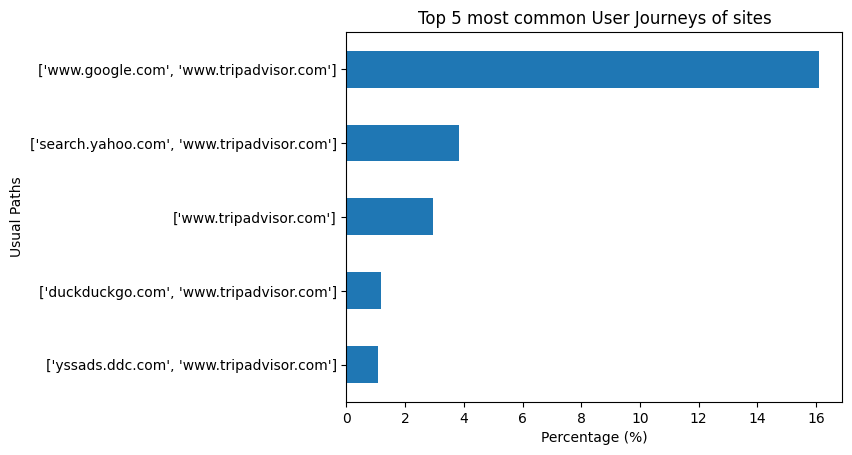

In [6]:
# Now we can see which are the most common user journys:
most_relevant_sequences = data['urlloc_reduced_link_str'].value_counts(
    normalize=True
).head(5)*100
most_relevant_sequences.sort_values(ascending=True).plot.barh()
plt.title('Top 5 most common User Journeys of sites')
plt.ylabel('Usual Paths')
plt.xlabel('Percentage (%)')
plt.show()

The most common path is by accessing trough google and arriving a trip advisor.
This path considers all possible consecutive duplicates such as the following cases and the extrapolation of them as well:

- ['google', 'trip_advisor']
- ['google', 'google', 'trip_advisor']
- ['google', 'google', 'google', 'trip_advisor']
- ['google', 'google', 'google', 'google', 'trip_advisor']
- ...

These paths represent about 16% of all the different paths that there are, and is the biggest categoty.
In this case we assume that by being and creating different querys in a same base url will be the same.
With this in mind we can identify categories and themes in the querys.

In [7]:
# We get the most common case
most_common_case = most_relevant_sequences.index[0]

# On the dataframe we look for instances that are this most common case.
most_common_case_df = data[data['urlloc_reduced_link_str'] == most_common_case]

In [8]:
# Here we can see the most common querys: 
most_common_case_df\
.url_link_list\
.apply(get_google_information_from_list)\
.explode()\
.astype('str')\
.value_counts()\
.head(10)

url_link_list
['']                                                9145
['tripadvisor']                                      218
['trip', 'advisor']                                  191
['food', 'near', 'me']                                98
['restaurants', 'near', 'me']                         79
['things', 'to', 'do', 'in', 'san', 'diego']          43
['sandals', 'barbados']                               36
['yehs', 'hotel', 'sydney', 'harbour', 'suites']      32
['rischort']                                          26
['google', 'maps']                                    25
Name: count, dtype: int64

In this case, we can see the top 10 querys, where there are some that are actually trivial stuff.
A google search on `tripadvisor` or `trip advisor` will probably lead into TripAdvisor.com
The same goes for the sepparate words.
What it might be more relevant is the next querys such as `food near me` or `restaurants near me`.
The next querys seem like specific cases. It might be better to see which words are the most used in the querys:

In [9]:
most_common_case_df\
.url_link_list\
.apply(get_google_information_from_list)\
.explode().explode()\
.astype('str')\
.value_counts()\
.head(20)

url_link_list
               9383
in             4252
to             3671
do             2056
things         1683
best           1509
restaurants    1324
hotel          1259
near           1177
hotels         1161
the             825
tripadvisor     816
beach           724
me              562
is              485
trip            478
restaurant      474
food            462
and             460
san             457
Name: count, dtype: int64

In this case, we can see the top 20 words in querys, we can see that a word-wise analysis
actualy reveals human-interpretable patterns such as 
`things to do`, or `best restaurants/hotels` maybe `near me` or `near beach`, and as well `restaurant food`.

With this information we can also create a wordcloud, where it is more interpretable:

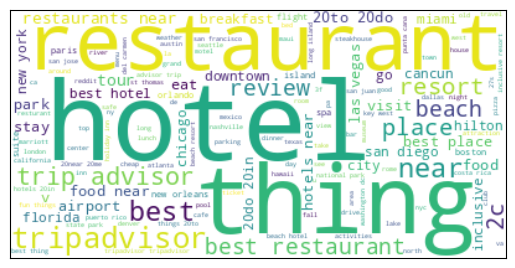

In [10]:
text = ' '.join(most_common_case_df.url_link_list.apply(get_google_information_from_list).explode().apply(lambda x: ' '.join(x)+ '.').to_list())
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

## Task 2: Finding the Longest Way to TripAdvisor (Optional)

### Objective:
Identify the longest journey (in terms of the number of clicks or unique pages visited) a user 
took before reaching TripAdvisor. Provide a comprehensive analysis of this journey, explaining what it 
may reveal about the user's behavior and inteio...ns

To do this, we are getting the longest journey by getting the largest number of unique **consecutive** pages visited in a session. 
This can be done by applying a `len` function to the `urlloc_reduced_link_list`, and then seeing who had the largest values.

In [11]:
# Identify the largest urlloc_reduced_link_list
longest_sessionid = data['urlloc_reduced_link_list'].apply(len).sort_values(ascending=False).head(1)

# Obtain the data with the longest_sessionid
longest_session = data[data.index==longest_sessionid.index[0]]

# Now we obtain the actual reduced journey
longest_session_user_journey = pd.Series(longest_session.urlloc_reduced_link_list.iloc[0])

# With help of the previous analysis we get which are the most relevant links that lead us to trip advisor,
# maybe there is some information there. 
relevant_links = set(pd.Series(data['urlloc_reduced_link_str'].value_counts(normalize=True).head(10).index).apply(string_to_list).sum())

In [12]:
# We can have all the url_link_list to see what specific actions the user did:

all_links_longest_session_user_journey = pd.Series(longest_session.url_link_list.iloc[0])
all_links_longest_session_user_journey_relevant_links_index_lst = []

index_link_dict = {}

# Let's iterate and see which links correspond to relevant links. 
for link in relevant_links:
    # In this step we see which links contain the most relevant link.
    all_links_longest_session_user_journey_relevant_links_index = pd.Series(
        all_links_longest_session_user_journey[
            all_links_longest_session_user_journey.apply(clean_with_replace_values).str.contains(link)
        ].index)
    # We append those links
    all_links_longest_session_user_journey_relevant_links_index_lst.append(
        all_links_longest_session_user_journey_relevant_links_index
    )
    # We save the information aswell in a dictionary
    index_link_dict[link] = all_links_longest_session_user_journey_relevant_links_index.to_list()

# now we filter the links depending on the information obtained.
relevant_all_links_longest_session_user_journey = all_links_longest_session_user_journey.loc[
        pd.Index(
            pd.concat(
                all_links_longest_session_user_journey_relevant_links_index_lst
            ).sort_values().to_list()
        )
    ]
# We create a dataframe to visualize the results more practially. 
relevant_all_links_longest_session_user_journey = pd.DataFrame(relevant_all_links_longest_session_user_journey)
relevant_all_links_longest_session_user_journey.rename(columns={0:'url'}, inplace=True)

In [13]:
for key in list(index_link_dict.keys())[::-1]:
    # Now for each key of relevant index, we are adding the corresponding key column
    relevant_all_links_longest_session_user_journey.loc[index_link_dict[key], 'key'] = key

In [14]:
# To gain information on the searches, we need to see what's goning on with some
# search engines such as google and yahoo (which are some of the most relevant).

# Google
google_condition = relevant_all_links_longest_session_user_journey.key=='www.google.com'
relevant_all_links_longest_session_user_journey.loc[google_condition, 'additional_info'] = relevant_all_links_longest_session_user_journey.loc[google_condition].url.apply(google_results_list)

# Yahoo
yahoo_condition = relevant_all_links_longest_session_user_journey.key=='search.yahoo.com'
relevant_all_links_longest_session_user_journey.loc[yahoo_condition, 'additional_info'] = relevant_all_links_longest_session_user_journey.loc[yahoo_condition].url.apply(google_results_list, start_parameter='p=')

In [15]:
relevant_all_links_longest_session_user_journey.tail()

,url,key,additional_info
2635,https://us.search.yahoo.com/yhs/search?hspart=...,search.yahoo.com,[francescatti]
2636,https://us.search.yahoo.com/yhs/search?hspart=...,search.yahoo.com,[francescatti]
2637,https://search.yahoo.com/yhs/search;_ylt=AwrEZ...,search.yahoo.com,"[la, ciotat%2c, france]"
2638,https://search.yahoo.com/,search.yahoo.com,[]
2639,https://www.tripadvisor.com/Tourism-g196675-La...,www.tripadvisor.com,NaN


In [16]:
# Now we can see what the used made to go to trip_advisor.

# BEWARE, +18 INFORMATION IS PRESENTED. 

By checking the most relevant urls of the whole journey, we can see that this user, accessed the following links (not in order):

In [17]:
relevant_all_links_longest_session_user_journey['key'].value_counts()

key
search.yahoo.com       25
www.youtube.com        12
www.google.com         10
www.facebook.com        3
www.bing.com            1
www.tripadvisor.com     1
Name: count, dtype: int64

By seeing the path and interpreting the intentions:

In [18]:
relevant_all_links_longest_session_user_journey

,url,key,additional_info
3,https://www.google.com/search?client=safari&rl...,www.google.com,[nakedpuddingwrestlingpics]
7,https://www.google.com/search?client=safari&rl...,www.google.com,[nakedpuddingwrestlingpics]
9,https://us.search.yahoo.com/yhs/search?hspart=...,search.yahoo.com,[nakedpuddingwrestlingpics]
10,https://us.search.yahoo.com/,search.yahoo.com,[]
12,https://us.search.yahoo.com/,search.yahoo.com,[]
219,https://www.youtube.com/watch?v=40cXhncf6_0,www.youtube.com,NaN
221,https://www.youtube.com/watch?v=40cXhncf6_0,www.youtube.com,NaN
285,https://www.youtube.com/watch?v=qPg5o-BkUNA,www.youtube.com,NaN
333,https://www.youtube.com/watch?v=rCgag2kKIxQ,www.youtube.com,NaN
335,https://www.youtube.com/watch?v=rCgag2kKIxQ,www.youtube.com,NaN


We can see that the user was doing it's own private affairs, that were not relevant to go to trip advisor, until he started with an specific question:
`[epouvantable, definition, %5d]`. This is a french word. Which might have put in the mind of this user french stuff. 
Then a consecutive search was  `[billy, ribbon]` which I don't understand that much. 

However the following search was `[french, violin, virtuosi]`, indicating that the french stuff is returning to his mind.

After this, additional input was provided to gain more information `[french, violin, virtuosi, wikipedia]`
Then we see that `[francescatti]` is a following search file,
We can see that the query is: `waltonviolinconcertofrancescattiszellclevelancordh`.
Then the user access to youtube and facebook, and then he again searches for `[francescatti]` in google and in yahoo
To finally search for `[la, ciotat%2c, france]`

With this information we can assume that french stuff and violinist/concert indicatives lead to the user to read about some musician. 
Finally the connection is to the french place `la citotat` that is actuall the place where this musician retired. 
